## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

<a id='probability'></a>
#### Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 
a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('landing_page == "new_page" & group != "treatment"').count() +\
df.query('landing_page != "new_page" & group == "treatment"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.   

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df[(df['group'] == 'treatment') == (df['landing_page'] == 'new_page')]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == 773192').index.get_values()

array([1899, 2893])

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(1899, axis=0, inplace = True)
df2.query('user_id == 773192').index.get_values()

/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


array([2893])

`4.`

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"').count() / df2.count()

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**The conversion proprtion for the control and treatment group are very close and therefore there's no strong evidence for landing a new page. **

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**
$$H_{0}: p_{old} >= p_{new}$$ <br>
$$H_{1}: p_{old} < p_{new}$$
**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>



a. What is the **convert rate** for $p_{new}$ under the null? 

In [17]:
df2.converted.mean()

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [18]:
df2.converted.mean()

0.11959708724499628

c. What is $n_{new}$?

In [19]:
n_new = df2.query('landing_page == "new_page"').landing_page.count()

d. What is $n_{old}$?

In [20]:
n_old = df2.query('landing_page == "old_page"').landing_page.count()

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [21]:
new_page_converted = df2.sample(n_new, replace = True).converted
new_page_converted.mean()

0.12008120569816255

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [22]:
old_page_converted = df2.sample(n_old, replace = True).converted
old_page_converted.mean()

0.11997329184850695

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [23]:
new_page_converted.mean() - old_page_converted.mean()

0.00010791384965559703

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [25]:
p_diffs = []
for _ in range(10000):
    b_sample = df2.sample(df2.shape[0], replace = True)
    new_page_converted_prop = b_sample.query('landing_page == "new_page"')['converted'].mean()
    old_page_converted_prop = b_sample.query('landing_page == "old_page"')['converted'].mean()
    p_diffs.append(new_page_converted_prop - old_page_converted_prop)

In [27]:
null_vals = np.random.normal(0, np.array(p_diffs).std(), len(p_diffs))

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  

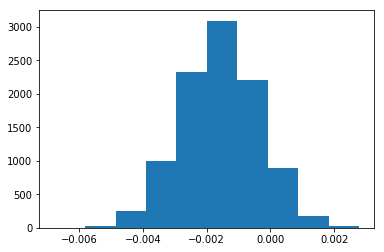

In [26]:
plt.hist(p_diffs);

** The distribution is normal distribution. This is expected by the cetral limit theorem.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
obs_diff

-0.0015782389853555567

In [30]:
(np.array(null_vals) > obs_diff).mean()

0.904

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In part j p-value was computed. The p-value is 0.904 which is higher than 0.05. The difference between the new and old page is not significant.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').landing_page.count()
n_new = df2.query('landing_page == "new_page"').landing_page.count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [37]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Since this is a one_tail test, the z-score should pass 1.65 (95% significance level) in order to show a significant difference. The p-value is also more than 0.05. These results agree with the findings in j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**A logistic regression with categorical variable will be preformed in this case.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [70]:
df2['intercept'] = 1

In [71]:
df2[['control', 'ab_page']] = pd.get_dummies(df['group'])
df2.drop('control', axis = 1, inplace = True)

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [45]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 14 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        08:43:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [46]:
np.exp(-1.9888)

0.13685955841614492

In [47]:
np.exp(-0.015)

0.9851119396030626

In [48]:
np.exp(-0.015) * np.exp(-1.9888)

0.13482198504454718

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

** For control group the proportion of conversion is 0.1369. For the treatment group the proportion of conversion is 0.1348. **

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?


**The  p-value associated with **ab_page** is 0.19. The null hypothesis with this value is $\beta_{1} = 0$ and the alternative hyputhesis is $\beta_{1} \neq 0$. Since the hypothesis is different, the p-value is different.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**The time range/time stamp might influence the converstion rate.It's possible that within certain timeframe one page is more significant than the other, or pass a certain timeframe one page is more significant than the other. Close examination of this variable will reduce the risk of coming to an errounous conclusion. However adding addtional terms will increase the chance of observing significant difference.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [55]:
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [61]:
df2 = pd.merge(df2, df3, left_on='user_id', right_on='user_id', how='left')

In [65]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])

In [73]:
df2.head()

,user_id,timestamp,group,landing_page,converted,country,CA,UK,US,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US,0,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US,0,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,US,0,0,1,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,US,0,0,1,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,US,0,0,1,1,0


In [81]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'UK','US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 14 Sep 2018   Pseudo R-squ.:               1.521e-05
Time:                        20:10:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [82]:
np.exp(-2.0375)

0.13035418933417164

In [83]:
np.exp(0.0507)

1.052007243765014

In [84]:
np.exp(0.0408)

1.0416437559600236

** When the country is CA the convertion rate for the old_page is 0.13. when the country is UK the conversion rate for UK is 0.13 \* 1.05, and the p-value is 0.074, indicating that this is not significant.  when the country is US the conversion rate for UK is 0.13 \* 1.04, and the p-value is 0.129, indicating that this is not significant. **

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [78]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page','UK','US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 14 Sep 2018   Pseudo R-squ.:               1.586e-05
Time:                        20:00:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3374
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0397      0.027    -76.594      0.000      -2.092      -1.987
ab_page        0.0043      0.011      0.373      0.709      -0.018       0.027
UK             0.0507      0.028      1.787      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [80]:
np.exp(-2.0397)

0.13006772534356661

In [79]:
np.exp(0.0043)

1.0043092582654238

In [76]:
np.exp(0.0507)

1.052007243765014

In [77]:
np.exp(0.0408)

1.0416437559600236

** When the country is CA the convertion rate for the old_page is 0.13. When the country is CA the convertion rate for the new_page is 0.13 \* 1.004. The p-value is 0.709 indicating that the conversion rate for new_page is not significant. when the country is UK the conversion rate for UK is 0.13 \* 1.05, and the p-value is 0.074, indicating that this is not significant.  when the country is US the conversion rate for UK is 0.13 \* 1.04, and the p-value is 0.129, indicating that this is not significant. **

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])